[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eneskelestemur/MolecularModeling/blob/main/Labs/lab05_machine_learning/Machine_learning.ipynb)

In [ ]:
# packages that need to be installed
%pip install rdkit numpy pandas matplotlib seaborn scikit-learn

# Machine Learning for Molecular Modeling

In this lab, we'll explore basic machine learning concepts using the scikit-learn library. We will cover:

* [Data Preprocessing](#data-preprocessing)
* [Regression](#regression)
    * [Linear Regression](#linear-regression)
    * [Decision Tree Regression](#decision-tree-regression)
    * [Random Forest Regression](#random-forest-regression)
    * [Support Vector Regression (SVR)](#support-vector-regression-svr)
* [Classification](#classification)
    * [Logistic Regression](#logistic-regression)
    * [Decision Tree Classification](#decision-tree-classification)
    * [Random Forest Classification](#random-forest-classification)
    * [Support Vector Classification (SVC)](#support-vector-classification-svc)
* [Unsupervised Learning](#unsupervised-learning)
    * [Principal Component Analysis (PCA)](#principal-component-analysis-pca)
    * [K-Means Clustering](#k-means-clustering)


## Data Preprocessing

We will use RDKit to convert the SMILES strings in our dataset to molecular fingerprints, which will serve as features for our machine learning models. We'll also split the data into training and testing sets and standardize the features for better performance.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator

# Load dataset
df = pd.read_csv('data/curated_solubility_dataset.csv')

# Convert Mols to molecular fingerprints
mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=2048)
def mols_to_fingerprints(mols, fp_gen=mfpgen):
    feature_vectors = []
    for mol in mols:
        fp = mfpgen.GetFingerprint(mol)
        feature_vectors.append(fp)
    return np.array(feature_vectors)

df['Fingerprint'] = mols_to_fingerprints([Chem.MolFromSmiles(smi) for smi in df['SMILES']]).tolist()

# Prepare features (X) and target (y) for regression and classification
X = np.array(df['Fingerprint'].tolist())
y_regression = df['LogS']
y_classification = np.where(df['LogS'] < -3, 1, 0)  # Binary classification (-3 threshold)

# Split into train and test sets
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X, y_regression, test_size=0.2, random_state=42)
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X, y_classification, test_size=0.2, random_state=42)

# Standardize the features - scale the features so magnitudes do not affect anything
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


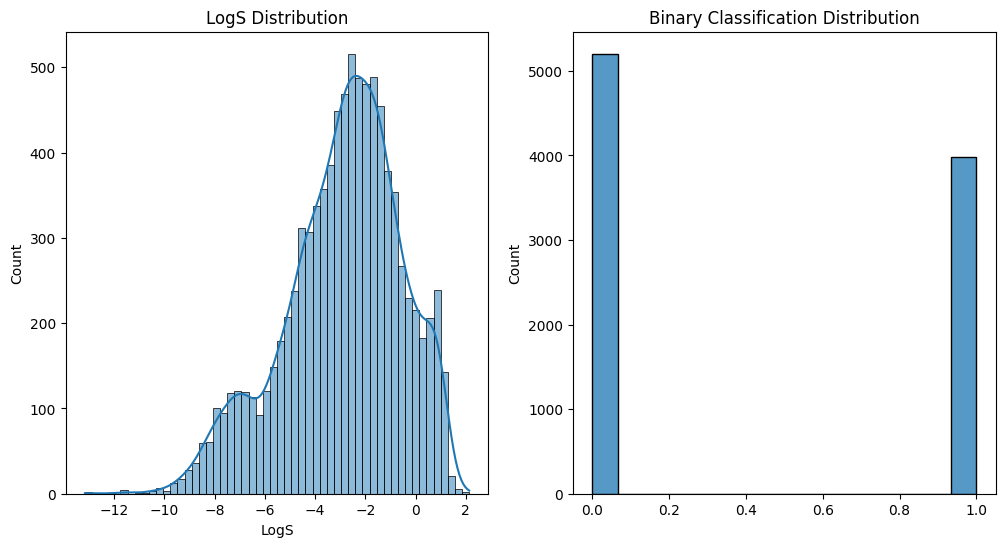

In [2]:
# plot the distribution of the target variable
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(y_regression, kde=True, ax=ax[0])
ax[0].set_title('LogS Distribution')
sns.histplot(y_classification, kde=False, ax=ax[1])
ax[1].set_title('Binary Classification Distribution')
plt.show()


## Regression

In regression, we predict continuous values, such as solubility (LogS). To evaluate the performance of our regression models, we use the following metrics:

* R² (Coefficient of Determination): Measures how well the model explains the variance in the target variable. The closer to 1, the better.
* Mean Squared Error (MSE): The average squared difference between predicted and true values.
* Mean Absolute Error (MAE): The average absolute difference between predicted and true values.

### Linear Regression

Linear Regression is a simple method that fits a straight line to the data. It minimizes the difference between the predicted and actual values.

Linear Regression R²: 0.5891283774754668
Linear Regression MSE: 2.4206099894090154
Linear Regression MAE: 1.1594662621009668


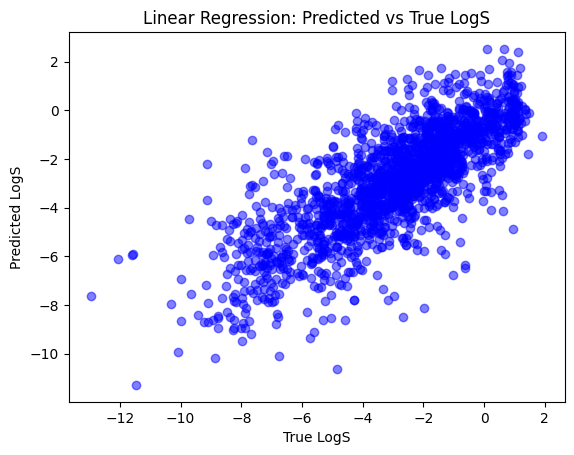

In [3]:
# Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

linear_reg = LinearRegression()
linear_reg.fit(X_train_scaled, y_train_reg)
y_pred_lr = linear_reg.predict(X_test_scaled)

# Calculate evaluation metrics
print("Linear Regression R²:", r2_score(y_test_reg, y_pred_lr))
print("Linear Regression MSE:", mean_squared_error(y_test_reg, y_pred_lr))
print("Linear Regression MAE:", mean_absolute_error(y_test_reg, y_pred_lr))

# Plot the predicted vs actual values
plt.scatter(y_test_reg, y_pred_lr, color='blue', alpha=0.5)
plt.xlabel('True LogS')
plt.ylabel('Predicted LogS')
plt.title('Linear Regression: Predicted vs True LogS')
plt.show()


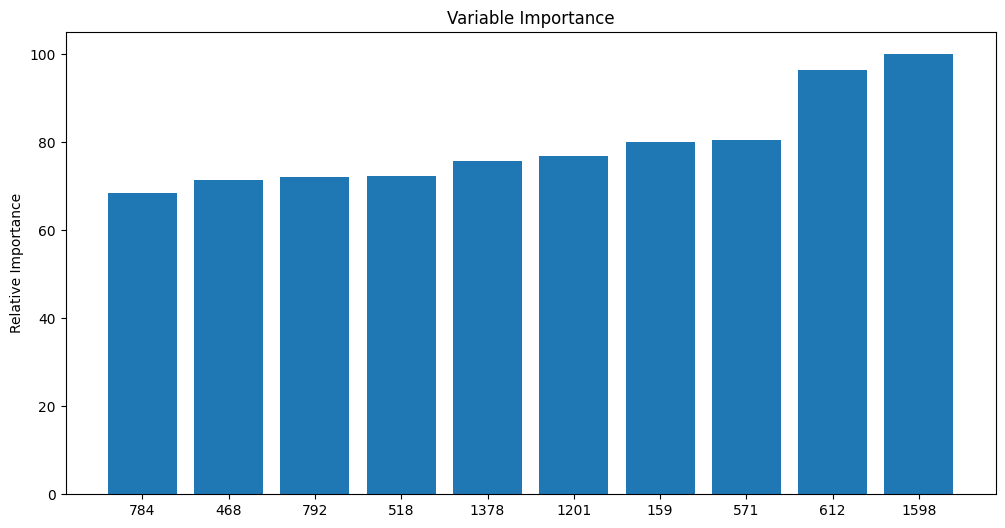

In [4]:
# plot feature importance
import seaborn as sns
import matplotlib.pyplot as plt

feature_importance = np.abs(linear_reg.coef_)

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

# only show top 10 features
sorted_idx = sorted_idx[-10:]
pos = pos[-10:]

plt.figure(figsize=(12, 6))
plt.bar(pos, feature_importance[sorted_idx], align='center')
plt.xticks(pos, sorted_idx)
plt.ylabel('Relative Importance')
plt.title('Variable Importance')
plt.show()


### Decision Tree Regression

Decision Trees partition the data by making splits based on the features. Each split attempts to reduce the error.

Decision Tree Regression R²: 0.4296004368432632
Decision Tree Regression MSE: 3.3604532531308915
Decision Tree Regression MAE: 1.2945827071634617


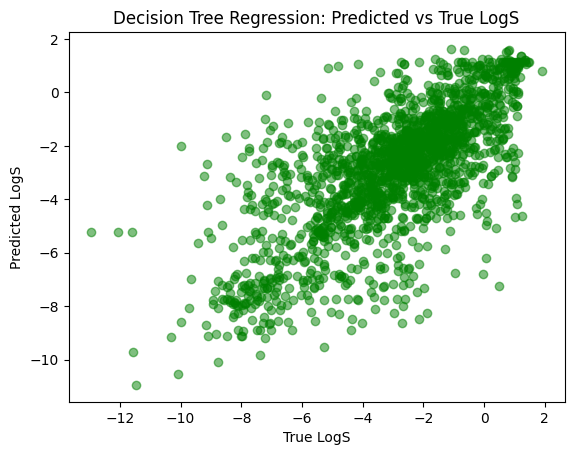

In [5]:
# Decision Tree Regression
from sklearn.tree import DecisionTreeRegressor, plot_tree

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train_scaled, y_train_reg)
y_pred_tree = tree_reg.predict(X_test_scaled)

# Calculate evaluation metrics
print("Decision Tree Regression R²:", r2_score(y_test_reg, y_pred_tree))
print("Decision Tree Regression MSE:", mean_squared_error(y_test_reg, y_pred_tree))
print("Decision Tree Regression MAE:", mean_absolute_error(y_test_reg, y_pred_tree))

# Plot the predicted vs actual values
plt.scatter(y_test_reg, y_pred_tree, color='green', alpha=0.5)
plt.xlabel('True LogS')
plt.ylabel('Predicted LogS')
plt.title('Decision Tree Regression: Predicted vs True LogS')
plt.show()


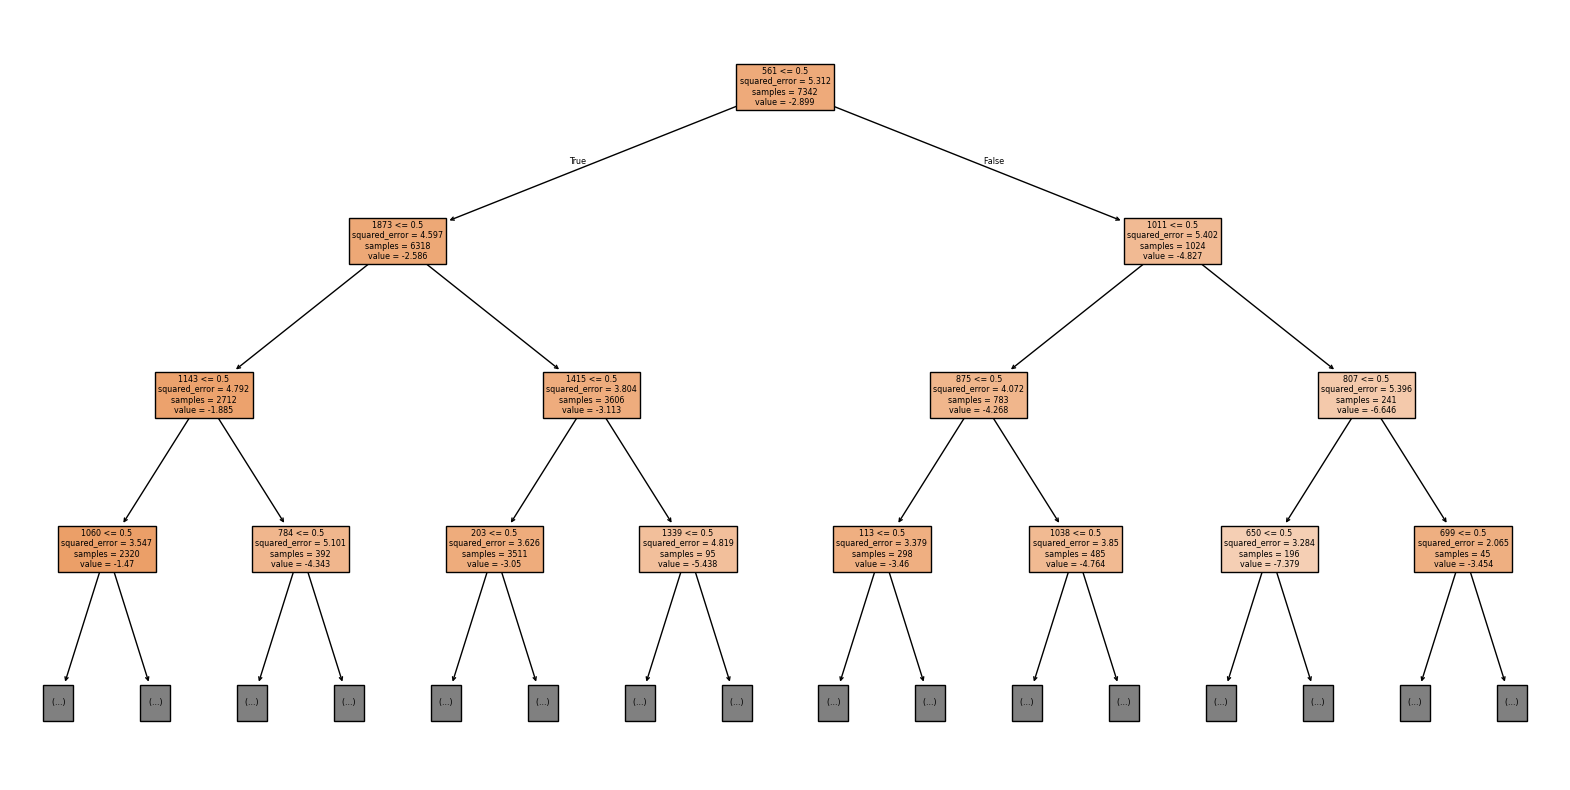

In [6]:
# plot tree structure
plt.figure(figsize=(20, 10))
plot_tree(tree_reg, filled=True, feature_names=np.arange(2048).tolist(), max_depth=3)
plt.show()


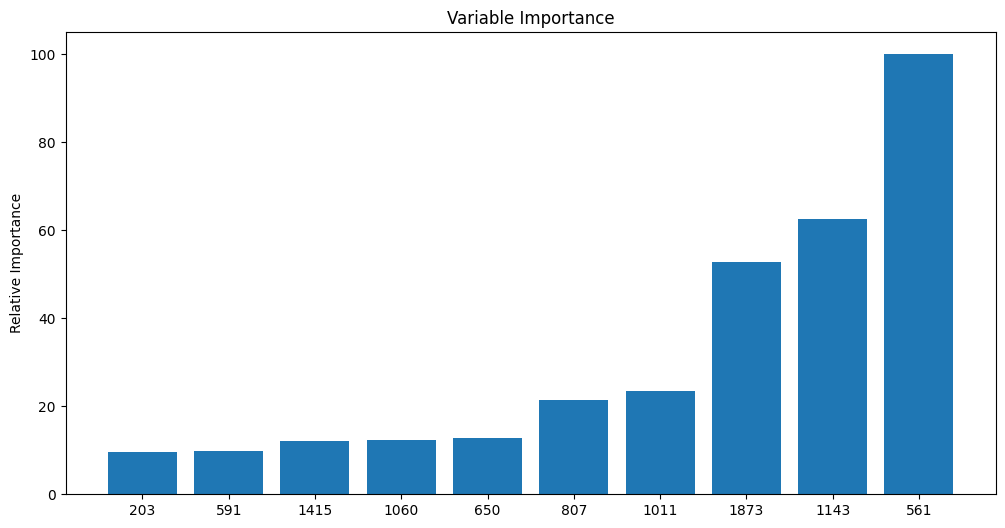

In [7]:
# plot feature importance
feature_importance = tree_reg.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

# only show top 10 features
sorted_idx = sorted_idx[-10:]
pos = pos[-10:]

plt.figure(figsize=(12, 6))
plt.bar(pos, feature_importance[sorted_idx], align='center')
plt.xticks(pos, sorted_idx)
plt.ylabel('Relative Importance')
plt.title('Variable Importance')
plt.show()


### Random Forest Regression

Random Forests are an ensemble of decision trees. Instead of relying on a single tree, multiple trees are built, and the results are averaged.

Random Forest Regression R²: 0.6798979241096585
Random Forest Regression MSE: 1.8858500807863832
Random Forest Regression MAE: 0.984328597966715


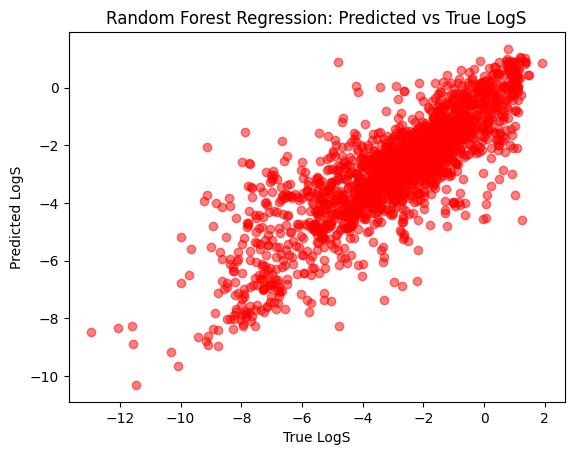

In [8]:
# Random Forest Regression
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train_scaled, y_train_reg)
y_pred_rf = rf_reg.predict(X_test_scaled)

# Calculate evaluation metrics
print("Random Forest Regression R²:", r2_score(y_test_reg, y_pred_rf))
print("Random Forest Regression MSE:", mean_squared_error(y_test_reg, y_pred_rf))
print("Random Forest Regression MAE:", mean_absolute_error(y_test_reg, y_pred_rf))

# Plot the predicted vs actual values
plt.scatter(y_test_reg, y_pred_rf, color='red', alpha=0.5)
plt.xlabel('True LogS')
plt.ylabel('Predicted LogS')
plt.title('Random Forest Regression: Predicted vs True LogS')
plt.show()


### Support Vector Regression (SVR)

Support Vector Regression fits a hyperplane between the data points, minimizing the error by ensuring most of the predictions fall within a defined margin.

SVM Regression R²: 0.6915569386225984
SVM Regression MSE: 1.8171621367923878
SVM Regression MAE: 0.9384335936681436


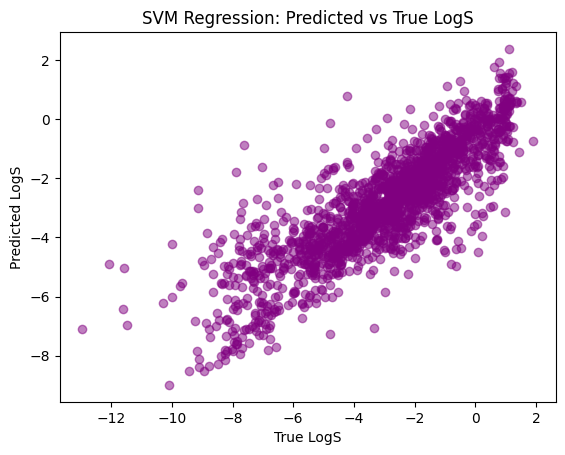

In [9]:
# SVM Regression
from sklearn.svm import SVR

svm_reg = SVR()
svm_reg.fit(X_train_scaled, y_train_reg)
y_pred_svm = svm_reg.predict(X_test_scaled)

# Calculate evaluation metrics
print("SVM Regression R²:", r2_score(y_test_reg, y_pred_svm))
print("SVM Regression MSE:", mean_squared_error(y_test_reg, y_pred_svm))
print("SVM Regression MAE:", mean_absolute_error(y_test_reg, y_pred_svm))

# Plot the predicted vs actual values
plt.scatter(y_test_reg, y_pred_svm, color='purple', alpha=0.5)
plt.xlabel('True LogS')
plt.ylabel('Predicted LogS')
plt.title('SVM Regression: Predicted vs True LogS')
plt.show()


## Classification Models

In classification, we predict a discrete label (e.g., whether a molecule is soluble or insoluble). To evaluate classification models, we use:

* Precision: The proportion of positive identifications that were actually correct.
* Recall: The proportion of actual positives that were identified correctly.
* F1 Score: The harmonic mean of precision and recall.
* Confusion Matrix: A table showing the number of true positives, false positives, true negatives, and false negatives.
* Accuracy: The overall rate of correct predictions.
* A confusion matrix visualizes the performance of the classifier by showing how many predictions fall into each category (true positives, false negatives, etc.).


### Logistic Regression

Logistic Regression is a linear classifier that calculates the probability of a binary outcome based on the input features.

Logistic Regression Accuracy: 0.8142701525054467
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1040
           1       0.80      0.77      0.78       796

    accuracy                           0.81      1836
   macro avg       0.81      0.81      0.81      1836
weighted avg       0.81      0.81      0.81      1836



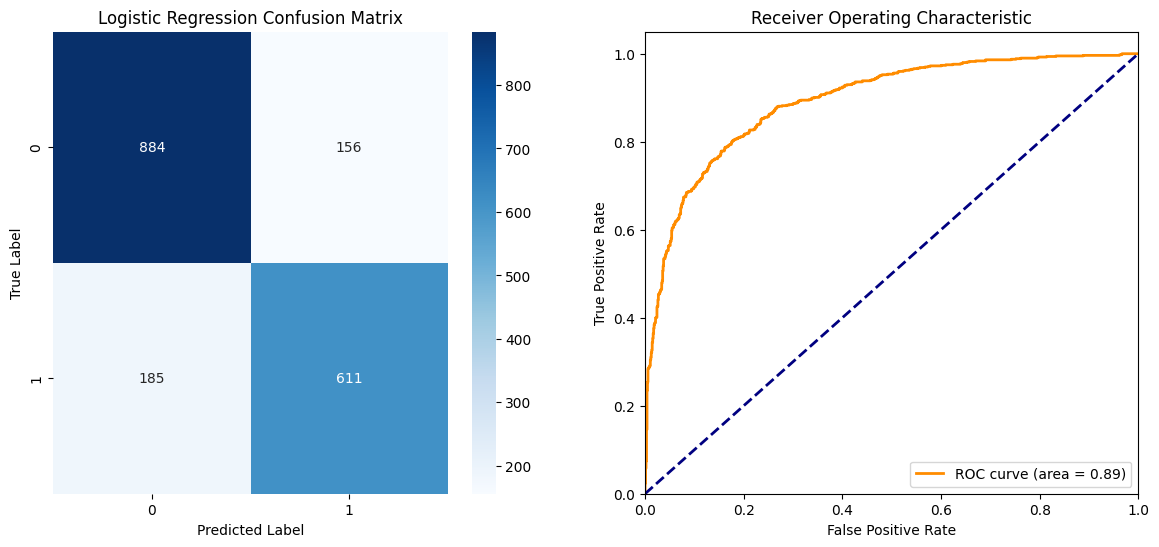

In [10]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns

logistic_clf = LogisticRegression(random_state=42, max_iter=1000)
logistic_clf.fit(X_train_class, y_train_class)
y_pred_log = logistic_clf.predict(X_test_class)

# Calculate Accuracy
print("Logistic Regression Accuracy:", accuracy_score(y_test_class, y_pred_log))

# Classification Report (Precision, Recall, F1-Score)
print(classification_report(y_test_class, y_pred_log))

# Confusion Matrix and ROC Curve
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Confusion Matrix as Heatmap
conf_matrix = confusion_matrix(y_test_class, y_pred_log)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Logistic Regression Confusion Matrix')
ax[0].set_ylabel('True Label')
ax[0].set_xlabel('Predicted Label')

# ROC Curve
y_pred_log_prob = logistic_clf.predict_proba(X_test_class)[:, 1]
fpr, tpr, _ = roc_curve(y_test_class, y_pred_log_prob)
roc_auc = roc_auc_score(y_test_class, y_pred_log_prob)
ax[1].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Receiver Operating Characteristic')
ax[1].legend(loc="lower right")
plt.show()



### Decision Tree Classification

Decision Trees for classification split the data into different classes based on the features.

Decision Tree Classifier Accuracy: 0.7696078431372549
              precision    recall  f1-score   support

           0       0.80      0.79      0.80      1040
           1       0.73      0.74      0.74       796

    accuracy                           0.77      1836
   macro avg       0.77      0.77      0.77      1836
weighted avg       0.77      0.77      0.77      1836



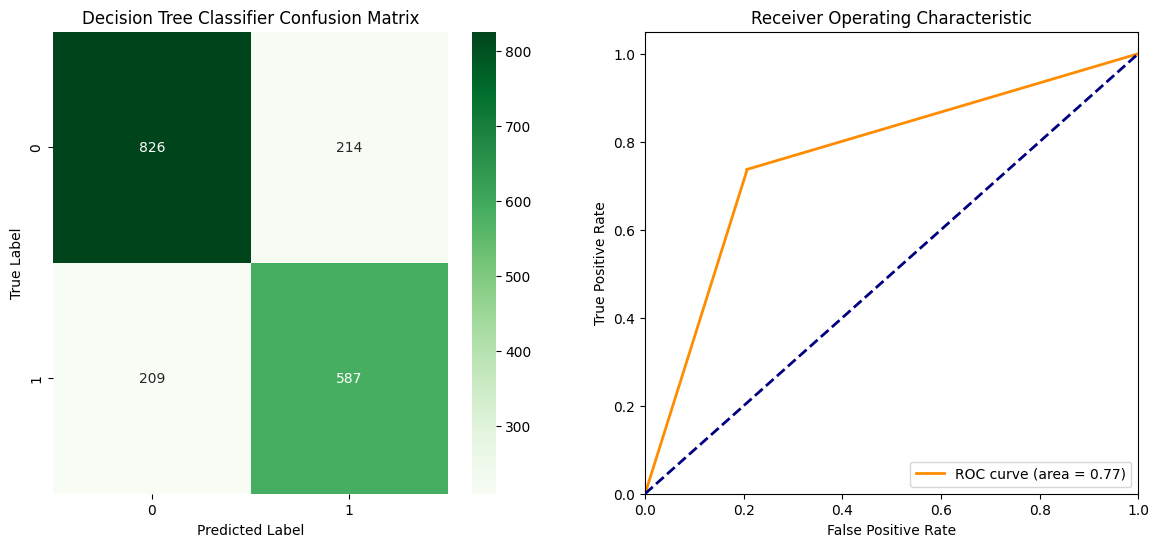

In [11]:
# Decision Tree Classification
from sklearn.tree import DecisionTreeClassifier, plot_tree

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train_class, y_train_class)
y_pred_tree_clf = tree_clf.predict(X_test_class)

# Calculate Accuracy
print("Decision Tree Classifier Accuracy:", accuracy_score(y_test_class, y_pred_tree_clf))

# Classification Report (Precision, Recall, F1-Score)
print(classification_report(y_test_class, y_pred_tree_clf))

# Confusion Matrix and ROC Curve
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Confusion Matrix as Heatmap
conf_matrix = confusion_matrix(y_test_class, y_pred_tree_clf)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', ax=ax[0])
ax[0].set_title('Decision Tree Classifier Confusion Matrix')
ax[0].set_ylabel('True Label')
ax[0].set_xlabel('Predicted Label')

# ROC Curve
y_pred_tree_prob = tree_clf.predict_proba(X_test_class)[:, 1]
fpr, tpr, _ = roc_curve(y_test_class, y_pred_tree_prob)
roc_auc = roc_auc_score(y_test_class, y_pred_tree_prob)
ax[1].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Receiver Operating Characteristic')
ax[1].legend(loc="lower right")
plt.show()



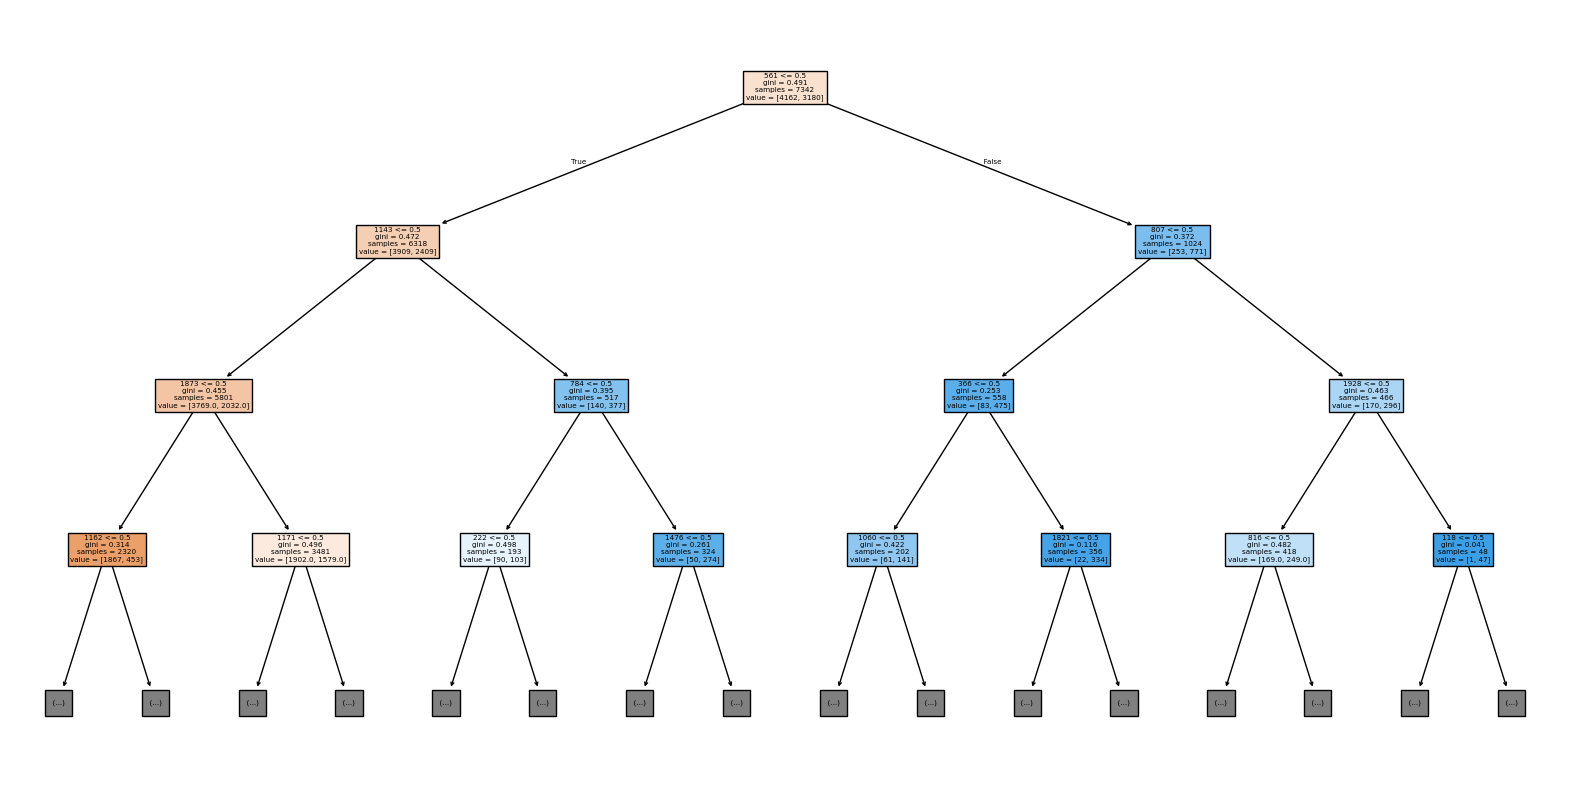

In [12]:
# plot tree structure
plt.figure(figsize=(20, 10))
plot_tree(tree_clf, filled=True, feature_names=np.arange(2048).tolist(), max_depth=3)
plt.show()


### Random Forest Classification

Random Forests build multiple decision trees and average the results for classification, reducing overfitting and improving accuracy.

Random Forest Classifier Accuracy: 0.8251633986928104
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      1040
           1       0.82      0.76      0.79       796

    accuracy                           0.83      1836
   macro avg       0.82      0.82      0.82      1836
weighted avg       0.83      0.83      0.82      1836



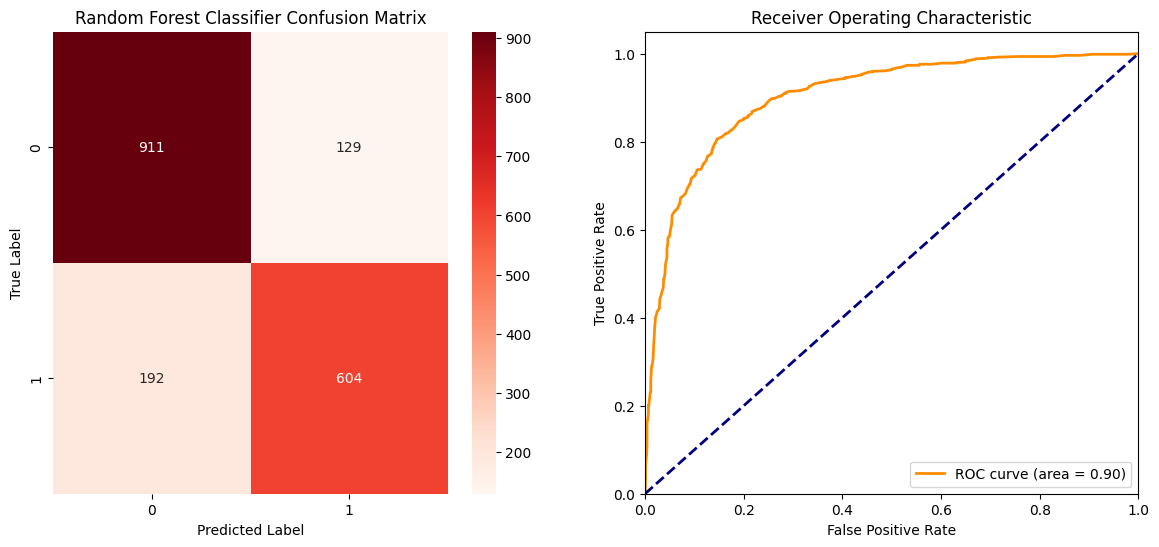

In [13]:
# Random Forest Classification
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_class, y_train_class)
y_pred_rf_clf = rf_clf.predict(X_test_class)

# Calculate Accuracy
print("Random Forest Classifier Accuracy:", accuracy_score(y_test_class, y_pred_rf_clf))

# Classification Report (Precision, Recall, F1-Score)
print(classification_report(y_test_class, y_pred_rf_clf))

# Confusion Matrix and ROC Curve
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Confusion Matrix as Heatmap
conf_matrix = confusion_matrix(y_test_class, y_pred_rf_clf)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', ax=ax[0])
ax[0].set_title('Random Forest Classifier Confusion Matrix')
ax[0].set_ylabel('True Label')
ax[0].set_xlabel('Predicted Label')

# ROC Curve
y_pred_rf_prob = rf_clf.predict_proba(X_test_class)[:, 1]
fpr, tpr, _ = roc_curve(y_test_class, y_pred_rf_prob)
roc_auc = roc_auc_score(y_test_class, y_pred_rf_prob)
ax[1].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Receiver Operating Characteristic')
ax[1].legend(loc="lower right")
plt.show()


### Support Vector Classification (SVC)

Support Vector Machines attempt to find the optimal boundary between classes that maximizes the margin between the points of each class.

SVM Classifier Accuracy: 0.8376906318082789
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1040
           1       0.84      0.77      0.80       796

    accuracy                           0.84      1836
   macro avg       0.84      0.83      0.83      1836
weighted avg       0.84      0.84      0.84      1836



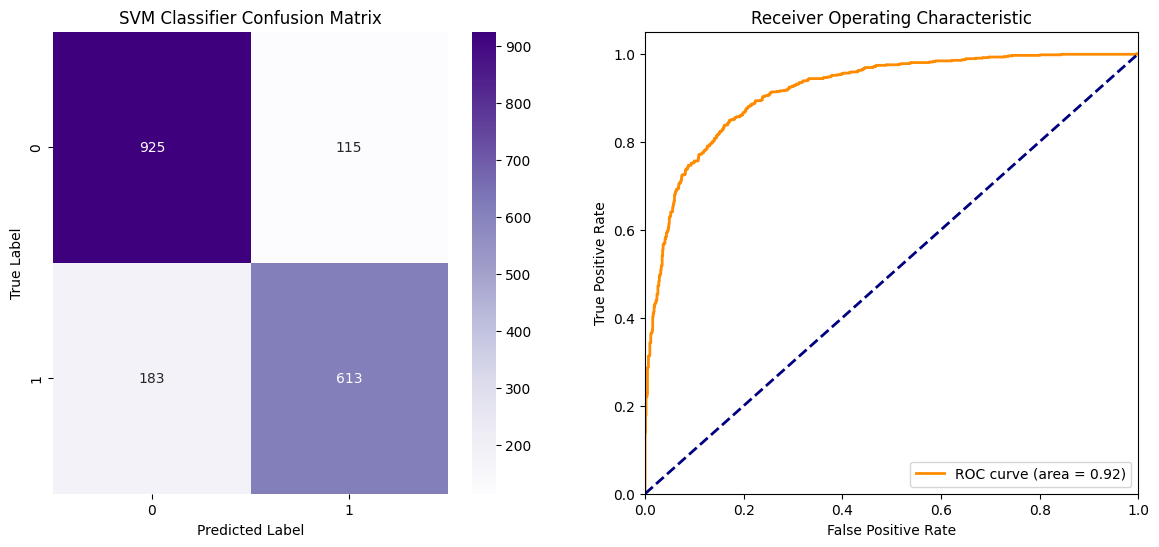

In [14]:
# SVM Classification
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train_class, y_train_class)
y_pred_svm_clf = svm_clf.predict(X_test_class)

# Calculate Accuracy
print("SVM Classifier Accuracy:", accuracy_score(y_test_class, y_pred_svm_clf))

# Classification Report (Precision, Recall, F1-Score)
print(classification_report(y_test_class, y_pred_svm_clf))

# Confusion Matrix and ROC Curve
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Confusion Matrix as Heatmap
conf_matrix = confusion_matrix(y_test_class, y_pred_svm_clf)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples', ax=ax[0])
ax[0].set_title('SVM Classifier Confusion Matrix')
ax[0].set_ylabel('True Label')
ax[0].set_xlabel('Predicted Label')

# ROC Curve
y_pred_svm_prob = svm_clf.decision_function(X_test_class)
fpr, tpr, _ = roc_curve(y_test_class, y_pred_svm_prob)
roc_auc = roc_auc_score(y_test_class, y_pred_svm_prob)
ax[1].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Receiver Operating Characteristic')
ax[1].legend(loc="lower right")
plt.show()


## Unsupervised Learning

In this section, we will apply Principal Component Analysis (PCA) and K-means Clustering to explore the dataset.

### Principal Component Analysis (PCA)

PCA reduces the dimensionality of the dataset while retaining most of the variance in the data. This allows us to visualize high-dimensional data in a 2D space.


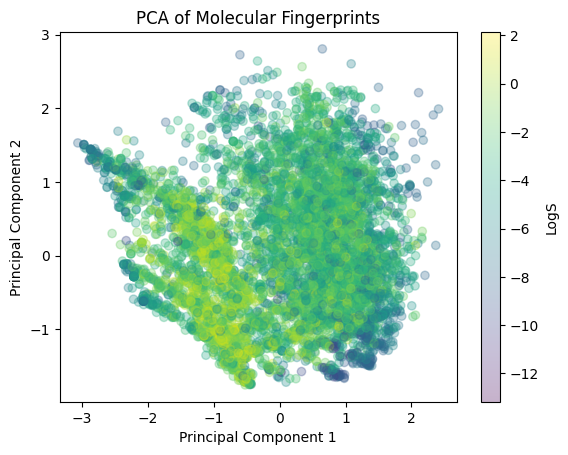

In [15]:
from sklearn.decomposition import PCA

# Apply PCA to the standardized training data
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

# Scatter plot of the first two principal components
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train_reg, cmap='viridis', alpha=0.3)
plt.title('PCA of Molecular Fingerprints')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='LogS')
plt.show()


### K-means Clustering

K-means Clustering attempts to group data points into distinct clusters based on their features. We'll apply K-means to the PCA-reduced data to find natural clusters.

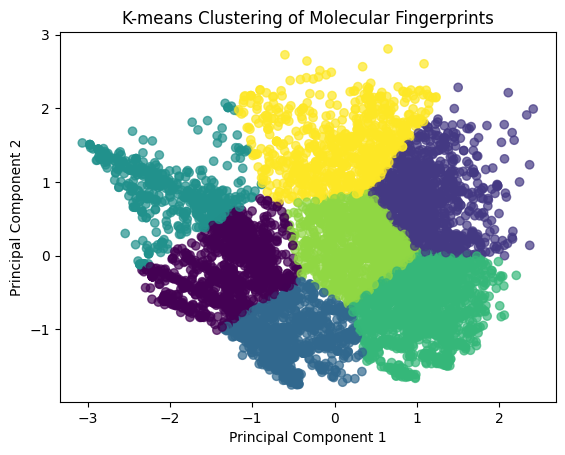

In [16]:
from sklearn.cluster import KMeans

# Apply K-means clustering
kmeans = KMeans(n_clusters=7, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca)

# Scatter plot of the clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.7)
plt.title('K-means Clustering of Molecular Fingerprints')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()
